Goal: Create a hierarchical clustering built upon both genotypic and phenotypic information. 

One proposal (40 total features): 
- 20 features for normalized abundance at T0 across native pHs
- 11 features for normalized abundance at T9 across perturbed pHs
- 9 features for structural and sequence-based information:
  - (3) Alpha helix, Beta sheet, Coil proportions
  - (2) Solvent-Accessible surface area (both total and average per residue)
  - (1) Radius of Gyration (compactness)
  - (1) Length
  - (1) Instability Index
  - (1) Isoelectric Point (pI) — pH at which the protein is net neutral




First, I need the ORFs for each of the 60 for which we have a compelete sequence after the first clustering. Then, I will use a cluster map to reduce redudancy, gather the relevant data for each one. 

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mgsa.helpers import plot
from mgsa.io import get_data
 
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


Start over, no conditioning out, but using the incomplete to complete map

In [182]:
KO = 'K00370'
map = '09'
Drug = 'None'

complete_ids = pd.read_csv(f'../out/aaseqs/{KO}/long_complete_orf_ids.txt', header = None)
complete_ids = complete_ids.values
print(complete_ids.shape, complete_ids.dtype)

all_ids = pd.read_csv(f'../out/orf_ids/cluster_ids_{map}_{KO}.tsv', sep = '\t', header=None)

map = pd.read_csv(f'../out/aaseqs/{KO}/incomplete_to_complete_seq_mapping.tsv', sep = '\t')
map = map.values
print(map[:,1].shape, map[:,1].dtype)
print(map)

T0data = np.zeros((len(complete_ids), 20))
T9data = np.zeros((len(complete_ids), 10, 11))

for i, id in enumerate(complete_ids):
    got_data = get_data(id, drug = Drug, KO=KO)
    T0data[i] += got_data[0]
    T9data[i] += got_data[1]

print(T9data[:,:,1].shape)

for i, id in enumerate(map[:,0]):
    complete_id = map[i, 1]
    idx = np.where(complete_ids == complete_id)[0][0]
    got_data = get_data(id, drug = Drug)
    T0data[idx] += got_data[0]
    T9data[idx] += got_data[1]






(57, 1) object
(451,) object
[['Soil11.scaffold_669406189_c1_1' 'Soil9.scaffold_209032411_c1_3'
  5.449392712550607]
 ['Soil11.scaffold_168782194_c1_1' 'Soil9.scaffold_209032411_c1_3'
  4.704142011834319]
 ['Soil11.scaffold_603781636_c1_1' 'Soil15.scaffold_116822102_c1_19'
  4.966360856269113]
 ...
 ['T0.scaffold_685359621_c1_1' 'Soil6.scaffold_312871021_c1_4'
  4.787878787878788]
 ['T0.scaffold_925671294_c1_1' 'Soil17.scaffold_274056314_c1_61'
  4.8262108262108265]
 ['T0.scaffold_409096425_c1_1' 'Soil5.scaffold_183283646_c1_24'
  5.014767932489452]]
(57, 10)


In [183]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler

strc_data = pd.read_csv(f'../out/structure_analysis/{KO}/structure_metrics_{KO}.tsv', sep='\t')
strc_data = strc_data.values
strc_data = strc_data[:, 1:]#remove the first column (orf names)

scaler = MinMaxScaler()
strc_data = scaler.fit_transform(strc_data)


data_abs = T0data
T0data = T0data / T0data.sum(axis = 1, keepdims=True)
T0data = np.nan_to_num(T0data, nan = 0)

data = T0data 
for i in range(10):
    T9temp = T9data[:,i,:]
    data_abs = np.hstack((data_abs, T9temp))
    T9temp = T9temp / T9temp.sum(axis = 1, keepdims=True)
    T9temp = np.nan_to_num(T9temp, nan = 0)
    data = np.hstack((data, T9temp))
    

pairwise_data = np.load(f'../out/aaseqs/{KO}/long_complete_pwalignment_scores.npy')
print(pairwise_data)
pairwise_data = scaler.fit_transform(pairwise_data)
np.savetxt(f"../out/K00370abundances/complete_abundances_nrm.tsv", data, delimiter = '\t', fmt = '%0.6f')
np.savetxt(f"../out/K00370abundances/complete_abundances_abs.tsv", data_abs, delimiter = '\t', fmt = '%0.6f')
data = np.hstack((data, pairwise_data))
data_abs = np.hstack((data_abs, pairwise_data))
#data = np.hstack((data, strc_data))


# weights = np.concatenate([
#     np.full(20, 1/np.sqrt(20)),    
#     np.full(110, 1/np.sqrt(110)) ,
#     np.full(57, 1/np.sqrt(57))
# ])

weights = np.concatenate([
    np.full(20, 1/np.sqrt(130)),    
    np.full(110, 1/np.sqrt(130)) ,
    np.full(57, 1/np.sqrt(57))
])


# weights = np.concatenate([
#     np.full(20, 1/np.sqrt(20)),    
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(10, 0),  
#     np.full(1, 1/np.sqrt(11)),
#     np.full(57, 1/np.sqrt(57)),    
# ])


weighted_data = data * weights 



[[6505. 2888. 2987. ... 2950. 5906. 2973.]
 [2888. 6662. 3282. ... 4721. 2914. 3331.]
 [2987. 3282. 6539. ... 3258. 3002. 4512.]
 ...
 [2950. 4721. 3258. ... 6743. 2975. 3230.]
 [5906. 2914. 3002. ... 2975. 6519. 3032.]
 [2973. 3331. 4512. ... 3230. 3032. 6674.]]


[28, 14, 25, 45, 3, 11, 37, 26, 21, 4, 53, 54, 15, 19, 6, 1, 44, 5, 52, 0, 27, 55, 30, 8, 36, 17, 41, 12, 10, 49, 20, 35, 31, 39, 33, 18, 13, 7, 34, 23, 38, 9, 2, 22, 51, 40, 32, 42, 47, 24, 29, 46, 43, 16, 50, 56, 48]


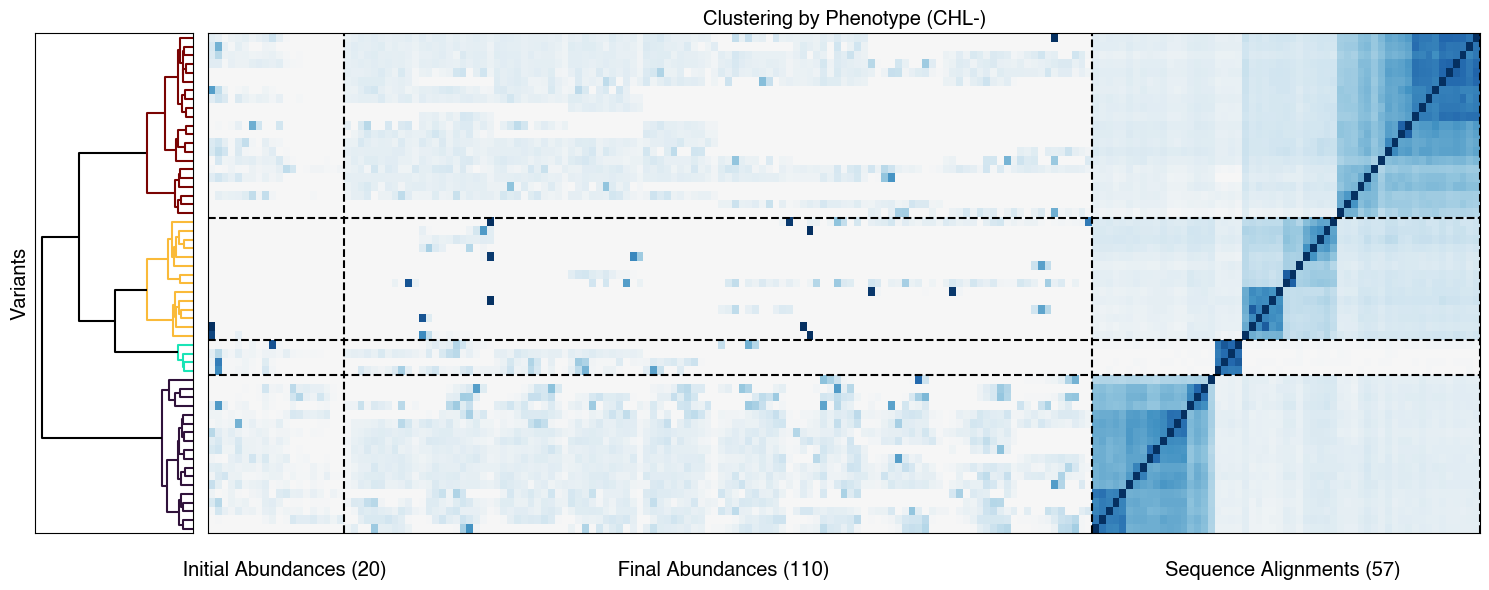

In [184]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import pdist
from matplotlib.colors import to_hex


Z = linkage(weighted_data, method='ward', metric='euclidean')
Z_optimal = optimal_leaf_ordering(Z, pdist(data, metric='euclidean'))

n_clusters = 4
clusters = fcluster(Z_optimal, t=n_clusters, criterion='maxclust')

dendro = dendrogram(Z_optimal, no_plot=True)
leaf_indices = dendro['leaves']

idx_to_cluster = {i: clusters[i] for i in range(len(clusters))}


next_node = len(clusters)
node_to_cluster = {}

for i, (left, right, _, _) in enumerate(Z_optimal):
    left, right = int(left), int(right)
    left_cluster = idx_to_cluster.get(left, node_to_cluster.get(left, -1))
    right_cluster = idx_to_cluster.get(right, node_to_cluster.get(right, -1))
    if left_cluster == right_cluster and left_cluster != -1:
        node_to_cluster[next_node] = left_cluster
    next_node += 1
    
    

#cluster_colors = ['#1f77b4', "#9729E0", "#610a70", "#210bcb"]
cmap = plt.cm.turbo # Or any other colormap (e.g., 'viridis', 'plasma')
cluster_colors = [to_hex(cmap(i)) for i in np.linspace(0, 1, n_clusters)]

def color_func(link_idx):
    cluster_id = node_to_cluster.get(link_idx, -1)
    if cluster_id != -1 and cluster_id <= len(cluster_colors):
        return cluster_colors[cluster_id - 1]
    return "#000000"  # default color for unclustered links


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [0.5, 4]})

dendrogram(Z_optimal,
           orientation='left',
           ax=ax1,
           color_threshold=max(Z_optimal[-n_clusters+1, 2], 0.1),
           link_color_func=color_func,
           above_threshold_color='k')

ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('Variants', fontname='Helvetica', fontsize = 'x-large')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.tick_params(left=False, bottom=False)

data = np.array(data)

rearranged_data = data[leaf_indices]
col_leaf_indices = leaf_indices+130*np.ones(57, dtype = int)
rearranged_data[:, 130:187] = rearranged_data[:, col_leaf_indices]

im = ax2.imshow(rearranged_data, aspect='auto', cmap='RdBu',
                interpolation='nearest', origin='lower', vmin = -1, vmax = 1)
#plt.colorbar(im, ax=ax2)


boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b + 0.5, color='black', linestyle='--')
    
ax2.axvline(19.5, color='black', linestyle='--')
ax2.axvline(129.5, color='black', linestyle='--')
ax2.axvline(186.5, color='black', linestyle='--')
ax2.set_xticks([])

ax2.set_title('Clustering by Phenotype (CHL-)', fontname='Helvetica', fontsize = 'x-large')
ax2.set_xlabel('\n Initial Abundances (20) \t \t \t \t \t \t \t \t \t \t \t \t \t \t \t \t \t        Final Abundances (110)   \t \t \t \t \t  \t \t \t \t  \t \t \t \t \t \t \t \t \t \t \t \t \t \t \t \t \t \t \t Sequence Alignments (57) \t \t \t \t \t \t \t \t \t \t', fontname='Helvetica', fontsize = 'x-large')

#ax2.set_ylabel('Variants', fontname='Helvetica', fontsize='x-large')

ax2.set_yticks([])
ax2.set_yticks([])
plt.tight_layout()

print(leaf_indices)
    
plt.show()

(57, 187)
(57, 187)
[17 21 35]


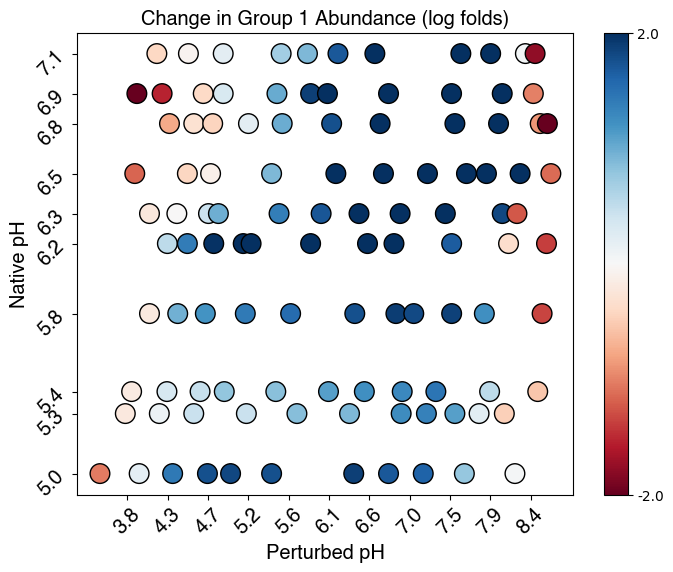

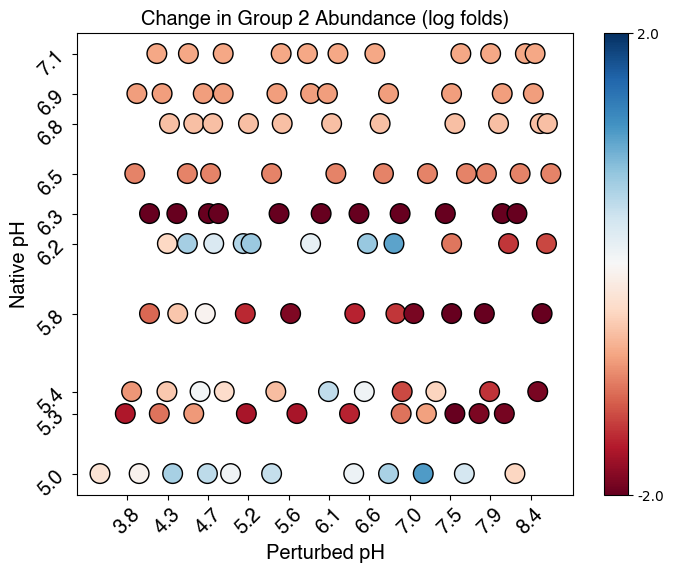

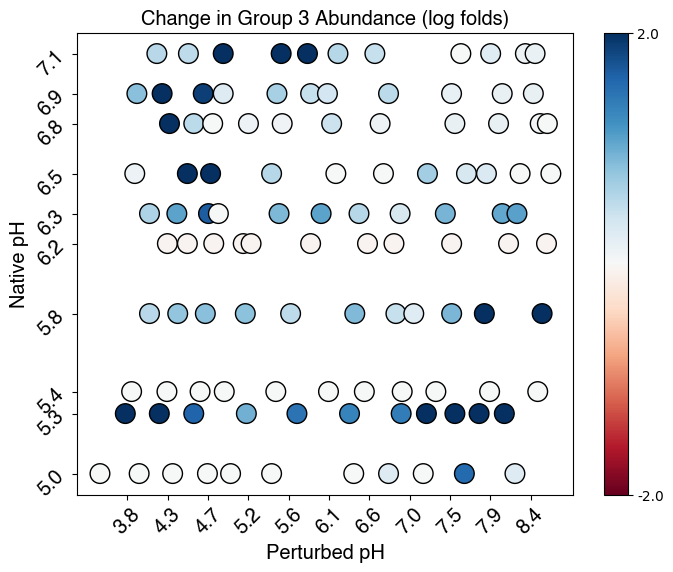

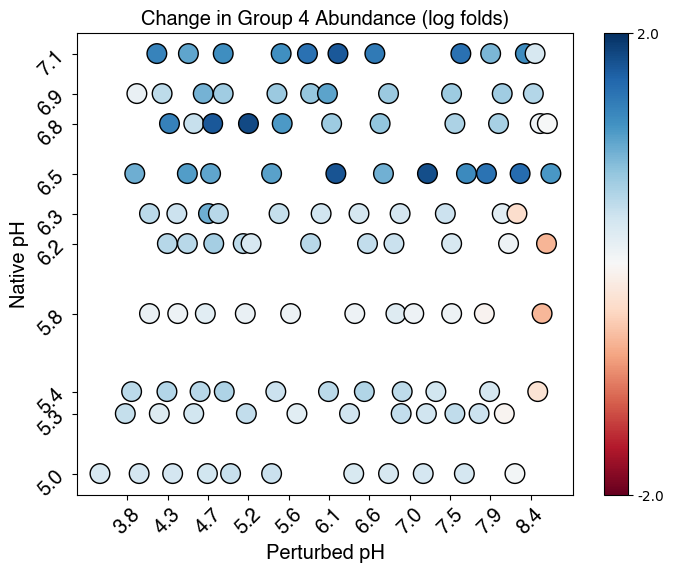

In [185]:

new_data = data_abs[leaf_indices]

print(data.shape)
print(new_data.shape)
print(boundaries)


groups = np.zeros((n_clusters,187))

for i, datum in enumerate(new_data):
    for j in range(1, n_clusters-1):
        if i > boundaries[j - 1] and i < boundaries[j]:
            groups[j] += datum
    if i < boundaries[0]:
        groups[0] += datum
    elif i > boundaries[n_clusters-2]:
        groups[n_clusters-1] += datum




selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]

#T0
groups_T0 = [np.zeros((10, 11)) for _ in range(n_clusters)]

for i in range(10): #native pH
    for j in range(n_clusters):
        groups_T0[j][i] = groups[j][selected][i]
        
# for j in range(n_clusters):
#     plot(groups_T0[j], f'Group {j+1} Abundance before Experiment', vmax = 1)

#T9
groups_T9 = [np.zeros((10, 11)) for _ in range(n_clusters)]

for i in range(10): #native pH
    for j in range(11): #perturbed pH
        for k in range(n_clusters):
            groups_T9[k][i][j] = groups[k][20 + 11*i + j]
            
# for i in range(n_clusters):
#     plot(groups_T9[i],  f'Group {i+1} Abundance after Experiment', vmin = 0, vmax = 1)
        
for i in range(n_clusters):
    plot(np.log((groups_T9[i] + 0.01*np.ones_like(groups_T9[i])) /  (groups_T0[i]+ 0.01 * np.ones_like(groups_T0[i]))), f'Change in Group {i+1} Abundance (log folds)', vmin = -2, vmax = 2, cmap = 'RdBu')
    #plot(groups_T9[i] - groups_T0[i], 'change subtraction', cmap = 'RdBu', vmin = -1, vmax = 1)

#change



['Soil11.scaffold_431547323_c1_2', 3]
['Soil11.scaffold_587233302_c1_1', 1]
['Soil11.scaffold_65427810_c1_20', 3]
['Soil11.scaffold_211583530_c1_6', 4]
['Soil12.scaffold_266712765_c1_2', 1]
['Soil14.scaffold_576820813_c1_40', 1]
['Soil14.scaffold_280216268_c1_12', 4]
['Soil14.scaffold_465502786_c1_2', 3]
['Soil14.scaffold_596019752_c1_119', 2]
['Soil15.scaffold_116822102_c1_19', 1]
['Soil15.scaffold_175810641_c1_3', 4]
['Soil15.scaffold_16321085_c1_6', 4]
['Soil15.scaffold_1255266399_c1_142', 1]
['Soil16.scaffold_436666653_c1_2', 2]
['Soil16.scaffold_804923086_c1_3', 1]
['Soil16.scaffold_313969256_c1_10', 1]
['Soil16.scaffold_1312607544_c1_3', 4]
['Soil17.scaffold_1045002370_c1_23', 1]
['Soil17.scaffold_918557319_c1_2', 4]
['Soil17.scaffold_1202428475_c1_2', 1]
['Soil17.scaffold_274056314_c1_61', 3]
['Soil17.scaffold_332687915_c1_2', 4]
['Soil3.scaffold_414071996_c1_8', 3]
['Soil3.scaffold_333288240_c1_8', 1]
['Soil3.scaffold_530221301_c1_2', 4]
['Soil3.scaffold_408070428_c1_2', 1]
['S

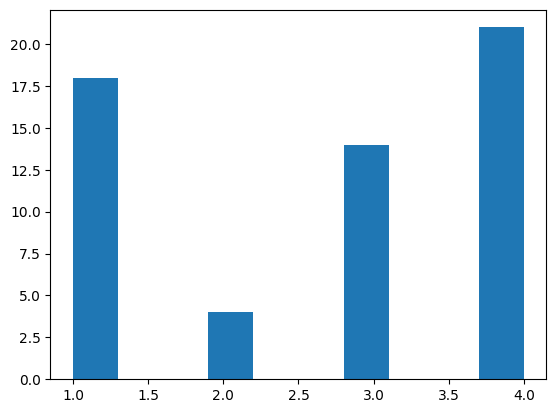

In [186]:
#created without any structural information, weighting phenotype and genotype equally

orf_list = pd.read_csv('../out/aaseqs/K00370/long_complete_orf_ids.txt', header=None)
orf_list = orf_list.values
orf_list = [orf[0] for orf in orf_list]


v1_clusters = []
for i in range(len(orf_list)):
    #print(orf_list[i], leaf_indices[i])
    cluster = 0
    if leaf_indices[i] < boundaries[0] + 0.5:
            cluster = 1
    for j in range(1, len(boundaries)):
        if leaf_indices[i] > boundaries[j-1] + 0.5 and leaf_indices[i] < boundaries[j]+0.5:
            cluster = j + 1
    j = len(boundaries) - 1
    if leaf_indices[i] > boundaries[j]+0.5:
        cluster = n_clusters
    v1_clusters.append([orf_list[i], cluster])
    

for element in v1_clusters:
    print(element)
    
    values = [item[1] for item in v1_clusters]
plt.hist(values)
print(values)

with open("../out/groups/assignments_K00370_v1.tsv", 'w') as f:
    for row in v1_clusters:
        f.write(f"{row[0]} {row[1]}\n")

### PCA to show genotype and phenotype vary together

(57, 130)
(57, 57)
Explained variance ratio (p): [0.17686659 0.0995724  0.0723671 ]
Explained variance ratio (g): [0.50918757 0.21565601 0.10417923]


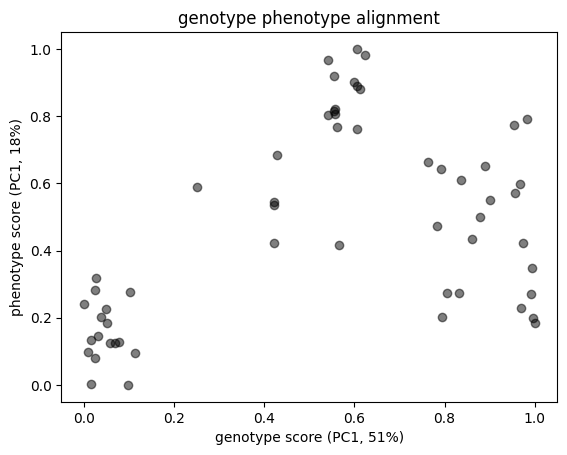

In [187]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

KO = 'K00370'
genotype_data = np.load(f'../out/aaseqs/{KO}/long_complete_pwalignment_scores.npy')
phenotype_data = pd.read_csv(f'../out/{KO}abundances/complete_abundances_nrm', sep = '\t', header = None)

print(phenotype_data.shape)
print(genotype_data.shape)



# Step 1: Center the data 
phenotype_data = phenotype_data - np.mean(phenotype_data, axis=0)
genotype_data = genotype_data - np.mean(genotype_data, axis=0)

# Step 2: Apply PCA
pca_p = PCA(n_components=3)  
pca_g = PCA(n_components=3)  
p_pca = pca_p.fit_transform(phenotype_data)
g_pca = pca_g.fit_transform(genotype_data)

# Step 3: Inspect results
print("Explained variance ratio (p):", pca_p.explained_variance_ratio_)

print("Explained variance ratio (g):", pca_g.explained_variance_ratio_)

# Step 4: Plot (if 2D)
# plt.scatter(p_pca[:, 0], p_pca[:, 1], alpha=0.7)
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('PCA Projection')
# plt.grid(True)
# plt.show()

# plt.scatter(g_pca[:, 0], g_pca[:, 1], alpha=0.7)
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('PCA Projection')
# plt.grid(True)
# plt.show()

# genotype vs phenotype

#clusters 
assignments = pd.read_csv("../out/groups/assignments_v1.tsv", sep = '\t', header = None).values

#normalize vectors 
g = np.zeros(len(g_pca[:, 0]))
p = np.zeros(len(p_pca[:, 0]))
for i in range(len(g)):
    g[i] = (g_pca[i, 0] - np.min(g_pca[:, 0])) / (np.max(g_pca[:, 0]) - np.min(g_pca[:, 0]))
    p[i] = (p_pca[i, 0] - np.min(p_pca[:, 0])) / (np.max(p_pca[:, 0]) - np.min(p_pca[:, 0]))


# for i in range(len(g)):
#     group = int(assignments[i][0][-1])
#     if  (group == 1):
#         c = 'Blue'
#     if  (group == 2):
#         c = 'Red'
#     if  (group == 3):
#         c = 'Yellow'
#     if  (group == 4):
#         c = 'Green' 
#     if (group == 5):
#         c = 'Purple'
#     if (group == 6):
#         c = 'Salmon'
#     plt.scatter(g[i], p[i], color = c, alpha = 0.7)
plt.scatter(g, p, color = 'Black', alpha = 0.5)
plt.xlabel('genotype score (PC1, 51%)')
plt.ylabel('phenotype score (PC1, 18%)')
plt.title('genotype phenotype alignment')
#plt.xlim(-0.1, 1.1)
plt.show()




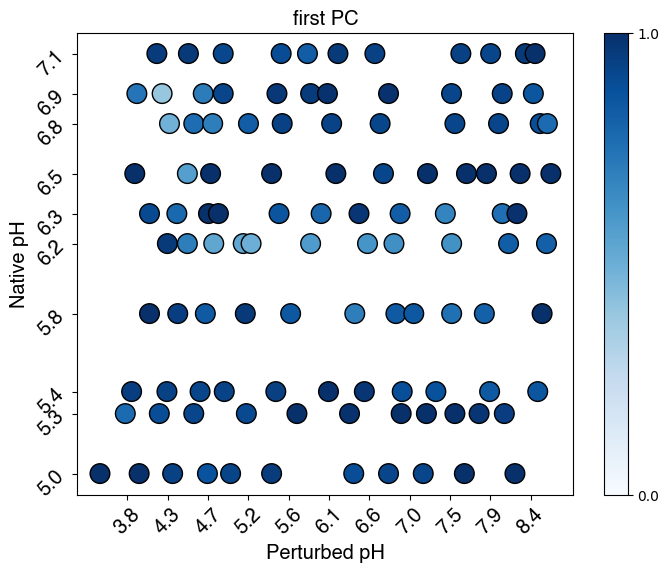

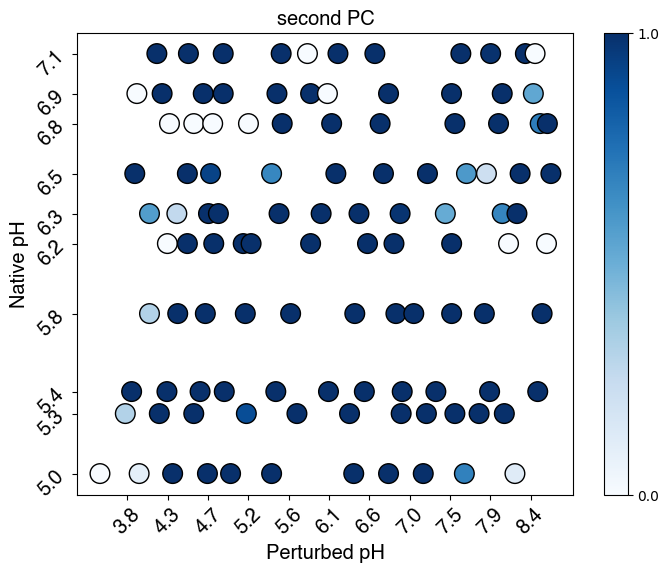

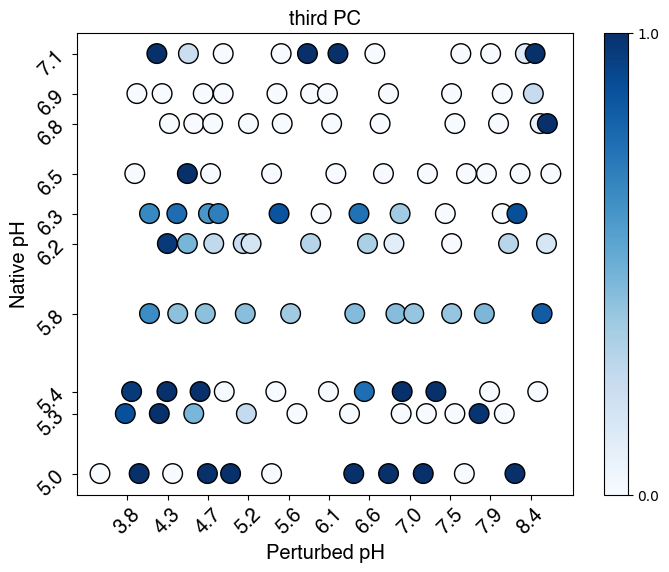

In [188]:
import numpy as np
from mgsa.helpers import plot
data_none = np.load('../out/sparse_regression/model1/pca_transformed_data_chl_neg.npy')
data_drug = np.load('../out/sparse_regression/model1/pca_transformed_data_chl_pos.npy')
plot((data_none[:,:,0] / data_drug[:,:,0]), 'first PC', vmin = 0, vmax = 1, cmap = 'Blues')
plot((data_none[:,:,1] / data_drug[:,:,1]), 'second PC', vmin = 0, vmax = 1, cmap = 'Blues')
plot((data_none[:,:,2] / data_drug[:,:,2]), 'third PC', vmin = 0, vmax = 1, cmap = 'Blues')